# Blog post
## Buisness questions:
1. Explore proffesional coding experience and satisfaction level, are there any interesting trends?
2. for survey participants coming from a non programming related degree, is there a relationship to the number/frequency of visits to stack overflow when compred to programming related backgrounds
3. If we inspect each country seperatly, what are the lowest 5 paying countries on a salary per hour calculation? what are the top 5 countries? 

## Dataset use
For this assignment i will be exploring the 2020 Stack Overflow Developer Survey results downloaded from:

https://insights.stackoverflow.com/survey/2020

In [225]:
#import all relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv('./survey_results_public.csv')
schema = pd.read_csv('./survey_results_schema.csv')
df.head()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,...,NaN,NaN,No,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,NaN,NaN,NaN,United States,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8


In [232]:
df.Country.unique().shape

(184,)

## Question 1
Explore proffesional coding experience and satisfaction level, are there any interesting trends?

In [3]:

#Lets start by extracting relevant columns and removing any rows containing missing values
q1_df = df[['JobSat','YearsCodePro']]
q1_df = q1_df.dropna(how='any',axis=0)



In [4]:
#lets look at coding experience column, investigate type and values we encounter 
q1_df['YearsCodePro'].dtypes
q1_df['YearsCodePro'].value_counts()

#we notice that there are 2 string values that won't convert well to int, lets replace them:
# 'Less than 1 year' -- > 0.5
# 'More than 50 years' --> 55

q1_df.replace('Less than 1 year', '0.5', inplace=True)
q1_df.replace('More than 50 years', '55', inplace=True)
# q1_df[q1_df['YearsCodePro']=='Less than 1 year']='0.5'
# q1_df[q1_df['YearsCodePro']=='More than 50 years']='55'

#now lets convert to floats
q1_df['YearsCodePro'] = q1_df['YearsCodePro'].astype(float)


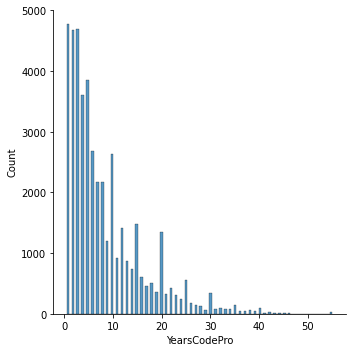

In [5]:
#lets investigate how job experience in yers is distrbuted
sns.displot(q1_df, x='YearsCodePro')

from the data we can observe the responders are mostly biased towards 0-10 years in the field, in a somewhat exponential distribution. this will make uderstanding the satisfaction level a bit tricky.. extracting the average or median will lean towards the majority of replies of this group and will not reflect well the satisfaction levels of more senior respondednt.

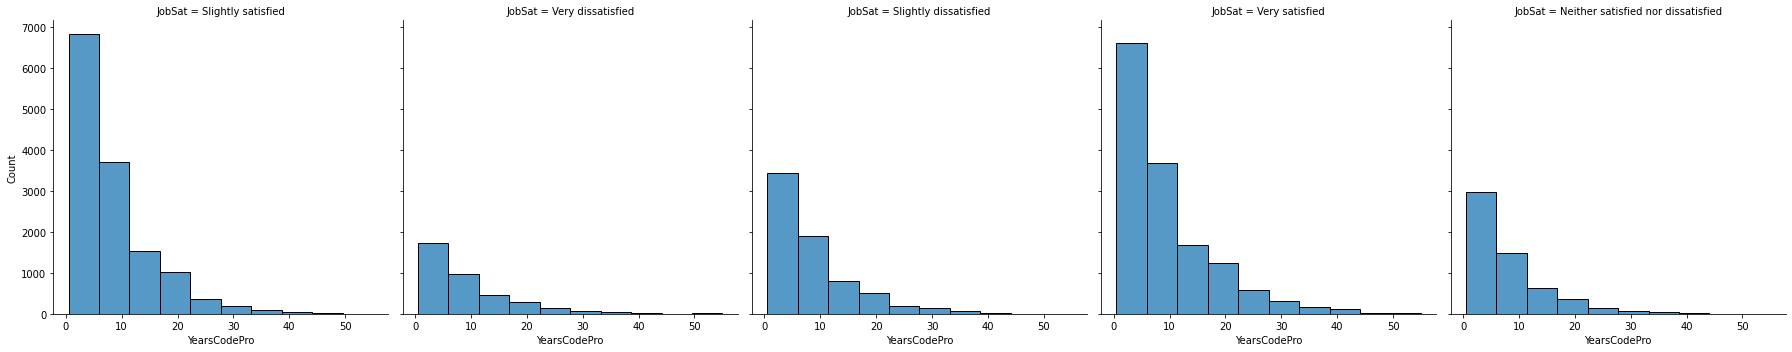

In [6]:
#lets explore splitting the replies by satisfaction levels, as new insights might appear:
sns.displot(q1_df, x="YearsCodePro", col="JobSat", multiple="dodge", bins=10)

As we can see, inspecting the hitograms of each group leans towards the 0-10 years bias. We will try our next approach, inspecting the relative portion of positive and negative and replies. The data is split into 3 groups: positive satisfaction, negative satisfaction and indifferent satisfaction for simplicity and robustness.

In [7]:
convert_sat ={'Neither satisfied nor dissatisfied':'ind',
 'Slightly dissatisfied':'neg',
 'Slightly satisfied':'pos',
 'Very dissatisfied':'neg',
 'Very satisfied':'pos'}

def pos_ind_neg(row):
    row['sat'] = convert_sat[row['JobSat']]
    return row
                
                             
q1_df = q1_df.apply(pos_ind_neg, axis=1)  
q1_df.head()

,JobSat,YearsCodePro,sat
0,Slightly satisfied,27.0,pos
1,Very dissatisfied,4.0,neg
3,Slightly dissatisfied,4.0,neg
5,Slightly satisfied,4.0,pos
6,Very satisfied,4.0,pos


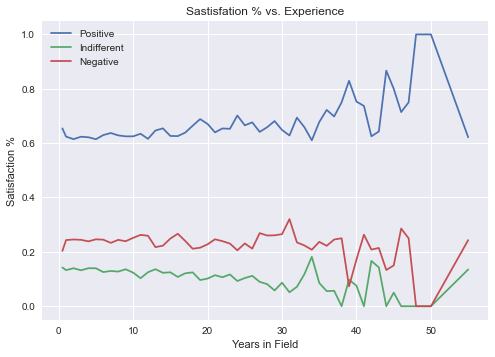

In [235]:
#now lets run on each expereince level group and calculate satisfaction level proportions
years = []
pos_ratio = []
neg_ratio = []
ind_ratio = []

for group, frame in q1_df.groupby(by='YearsCodePro'):
    pos_counts = frame[frame['sat'].eq('pos')].count()[0]
    neg_counts = frame[frame['sat'].eq('neg')].count()[0]
    ind_counts = frame[frame['sat'].eq('ind')].count()[0]
    total = pos_counts + neg_counts + ind_counts
    
    years.append(group)
    pos_ratio.append(pos_counts/total)
    neg_ratio.append(neg_counts/total)
    ind_ratio.append(ind_counts/total)
    
 
# Plot
plt.style.use('seaborn')
plt.plot(years,pos_ratio,years, ind_ratio, years, neg_ratio)
plt.legend(['Positive','Indifferent', 'Negative'],loc='upper left')
plt.xlabel('Years in Field')
plt.ylabel('Satisfaction %')
plt.title('Sastisfation % vs. Experience')
plt.show()


# Question 2

For survey participants coming from a non programming related degree, is there a relationship to the number/frequency of visits to stack overflow when compred to programming related backgrounds

In [9]:
#lets explore the presented categories
df_q2 = pd.read_csv('./survey_results_public.csv')
schema = pd.read_csv('./survey_results_schema.csv')

df.UndergradMajor.value_counts()

Computer science, computer engineering, or software engineering                   31582
Another engineering discipline (such as civil, electrical, mechanical, etc.)       4754
Information systems, information technology, or system administration              4071
A natural science (such as biology, chemistry, physics, etc.)                      2205
Mathematics or statistics                                                          1849
Web development or web design                                                      1789
A business discipline (such as accounting, finance, marketing, etc.)               1375
A humanities discipline (such as literature, history, philosophy, etc.)            1007
A social science (such as anthropology, psychology, political science, etc.)        933
Fine arts or performing arts (such as graphic design, music, studio art, etc.)      725
I never declared a major                                                            453
A health science (such as nursin

In [10]:
#For the purpose of answering this question, we will split the df into 2 groups, 
#Group 1 - CS background:
# 1.Computer science, computer engineering, or software engineering
# 2.Information systems, information technology, or system administration
# 3.Web development or web design

#Group 2 - All other responders

cs_ed = df_q2[df_q2['UndergradMajor'].isin(['Computer science, computer engineering, or software engineering',
                              'Information systems, information technology, or system administration',
                              'Web development or web design'])]

non_cs_ed = df_q2.drop(cs_ed.index,axis=0)

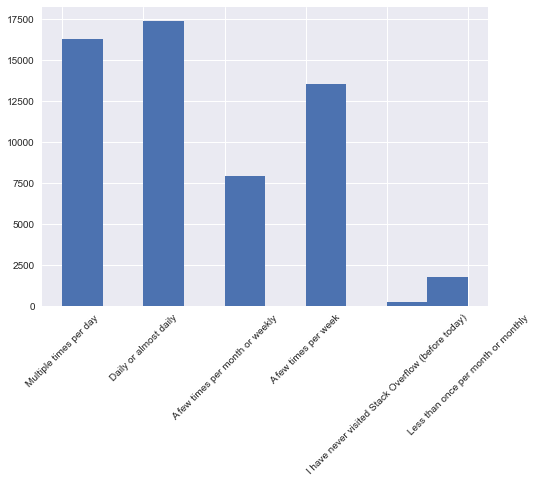

In [11]:
#next, lets explore stack overflow visits
#the desired column:
#  SOVisitFreq

df_q2['SOVisitFreq'].hist(xrot=45);

Text(2, -0.5, 'Negative values show % change\nwhen CS < non-CS')

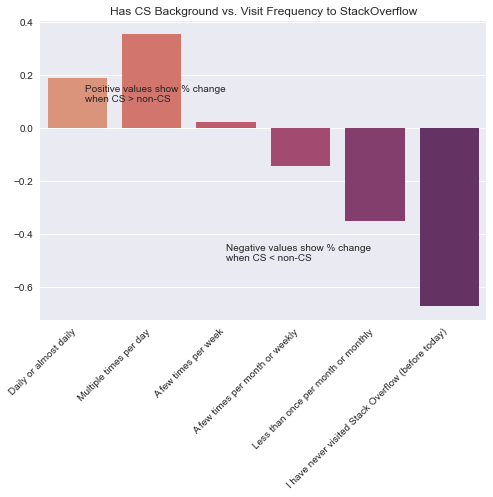

In [254]:
#now lets inspect the ratio between the two groups, CS background vs. non-CS background in terms of SO visiting frequency 

#lets group the number of responders to frequency reply groups
cs = cs_ed['SOVisitFreq'].value_counts()
non_cs = non_cs_ed['SOVisitFreq'].value_counts()

# lets normalize per total number of respondents in each group, this will deal with the groups being un-even
cs=cs/cs_ed.shape[0]
non_cs=non_cs/non_cs_ed.shape[0]

#find the ratio, positive values are attributed to the CS group, negative to the non CS group
vals = cs/non_cs-1

#plot the results
g = sns.barplot(x=vals.index, y=vals.values,palette="flare");
g.set_xticklabels(g.get_xticklabels(),rotation=45, horizontalalignment='right');
g.set_title('Has CS Background vs. Visit Frequency to StackOverflow');
g.text(0.1,0.1,'Positive values show % change\nwhen CS > non-CS')
g.text(2,-0.5,'Negative values show % change\nwhen CS < non-CS')

## Question 3
If we inspect each country seperatly, what are the lowest 5 paying countries on a salary per hour calculation? what are the top 5 countries?

In [237]:
#extract relevant columns
hours_and_contry = df[['Country','WorkWeekHrs','ConvertedComp']]

#remove missing values
hours_and_contry = hours_and_contry.dropna()

#group by country and calculate average for each value
hrs = hours_and_contry.groupby(by='Country').mean()

#calculate ratio 
hrs['ratio'] = hrs['ConvertedComp'] /55 / hrs['WorkWeekHrs']






In [238]:
#least profitable countries to work in
bottom_5 = hrs.sort_values(by='ratio').iloc[0:5]['ratio']
bottom_5

Country
Lesotho              0.010909
Brunei Darussalam    1.563636
Niger                1.997576
Sudan                2.051079
Guinea               2.295273
Name: ratio, dtype: float64

In [239]:
#most profitable countries to work in
top_5 = hrs.sort_values(by='ratio', ascending=False).iloc[0:5]['ratio']
top_5

Country
Nomadic                             135.058579
Lao People's Democratic Republic     97.790803
United States                        90.390625
Ireland                              84.819914
United Kingdom                       65.326512
Name: ratio, dtype: float64